In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os

# Set the directory where your files are stored
directory = '/content/drive/MyDrive/Extracted-features'

# List of CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Iterate through each CSV file and print the number of rows and columns
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    print(f"File: {file}")
    print(f"Number of samples (rows): {df.shape[0]}")
    print(f"Number of features (columns): {df.shape[1]}")
    print("-" * 40)


File: 1018_8320_EOG-ROC-M1_N2_stage.csv
Number of samples (rows): 486
Number of features (columns): 7681
----------------------------------------
File: 1018_8320_EOG-ROC-M1_N1_stage.csv
Number of samples (rows): 42
Number of features (columns): 7681
----------------------------------------
File: 1018_8320_EOG-ROC-M1_N3_stage.csv
Number of samples (rows): 243
Number of features (columns): 7681
----------------------------------------
File: 1018_8320_EOG-ROC-M1_wake_stage.csv
Number of samples (rows): 113
Number of features (columns): 7681
----------------------------------------
File: 1018_8320_EOG-ROC-M1_Rem_stage.csv
Number of samples (rows): 185
Number of features (columns): 7681
----------------------------------------


# Paper: Douzas and Bacao, "Effective Data Generation for Imbalanced Learning Using Conditional Generative Adversarial Networks" (Expert Systems with Applications, 2018).
# Key Idea: Cluster-SMOTE first clusters the dataset (e.g., with KMeans), then generates synthetic samples within each cluster, preserving local structure and diversity.

In [ ]:
!pip install imbalanced-learn


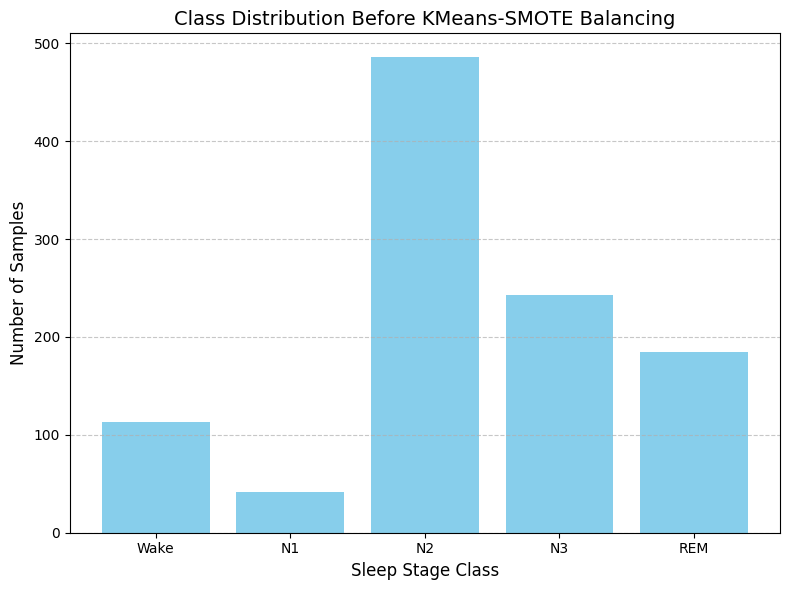

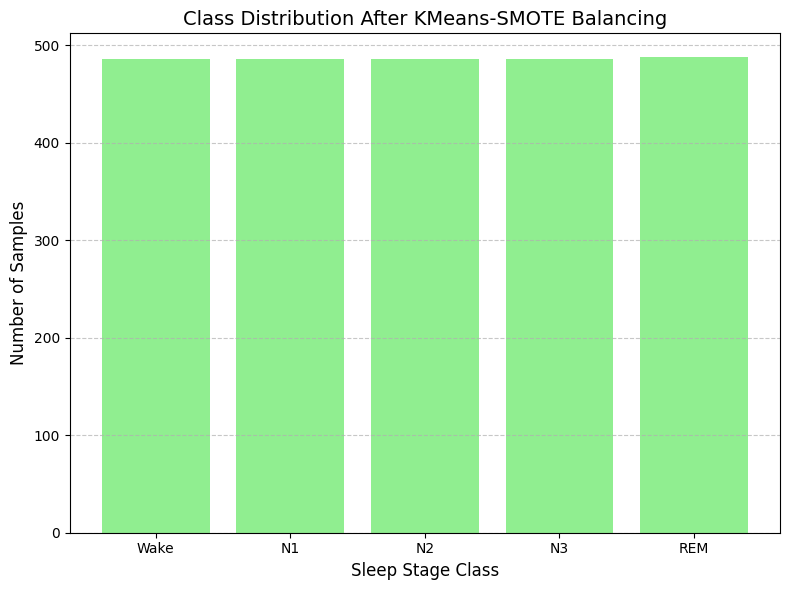

<ipython-input-9-fb56bd49dbcc>:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_df['label'] = y_balanced


Script Execution Time: 309.57 seconds
Balanced dataset saved: /content/drive/MyDrive/Extracted-features/balanced_dataset.csv
Number of samples per class after balancing:
label
4    488
2    486
1    486
3    486
0    486
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd
import time
from imblearn.over_sampling import KMeansSMOTE
import matplotlib.pyplot as plt

# Record the start time
start_time = time.time()

# Directory of CSV files
directory = '/content/drive/MyDrive/Extracted-features'

# List of original CSV files
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv') and '_transposed' not in f]

# Load data for all classes
dataframes = []
labels = []

# Class label mapping (example based on filenames)
label_map = {
    'wake': 0,
    'n1': 1,
    'n2': 2,
    'n3': 3,
    'rem': 4
}

# Read and label each file
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)

    # Identify label from filename
    label = None
    for key in label_map:
        if key in file.lower():
            label = label_map[key]
            break

    if label is None:
        continue  # Skip unrecognized file

    df['label'] = label
    dataframes.append(df)

# Combine all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Fill missing values with column means
X = X.fillna(X.mean())

# Plot class distribution before balancing
plt.figure(figsize=(8, 6))
plt.bar(y.value_counts().index, y.value_counts().values, color='skyblue')
plt.xlabel('Sleep Stage Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution Before KMeans-SMOTE Balancing', fontsize=14)
plt.xticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Apply KMeans-SMOTE balancing
kmeans_smote = KMeansSMOTE(cluster_balance_threshold=0.01, random_state=42)
X_balanced, y_balanced = kmeans_smote.fit_resample(X, y)

# Plot class distribution after balancing
plt.figure(figsize=(8, 6))
plt.bar(pd.Series(y_balanced).value_counts().index, pd.Series(y_balanced).value_counts().values, color='lightgreen')
plt.xlabel('Sleep Stage Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution After KMeans-SMOTE Balancing', fontsize=14)
plt.xticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save the balanced dataset as CSV
balanced_df = pd.DataFrame(X_balanced)
balanced_df = pd.concat([pd.DataFrame(X_balanced), pd.Series(y_balanced, name='label')], axis=1)
balanced_file_path = os.path.join(directory, 'balanced_dataset.csv')
balanced_df.to_csv(balanced_file_path, index=False)

# Record the end time
end_time = time.time()
execution_time = end_time - start_time

# Print timing analysis
print(f"Script Execution Time: {execution_time:.2f} seconds")
print("Balanced dataset saved:", balanced_file_path)
print("Number of samples per class after balancing:")
print(balanced_df['label'].value_counts())


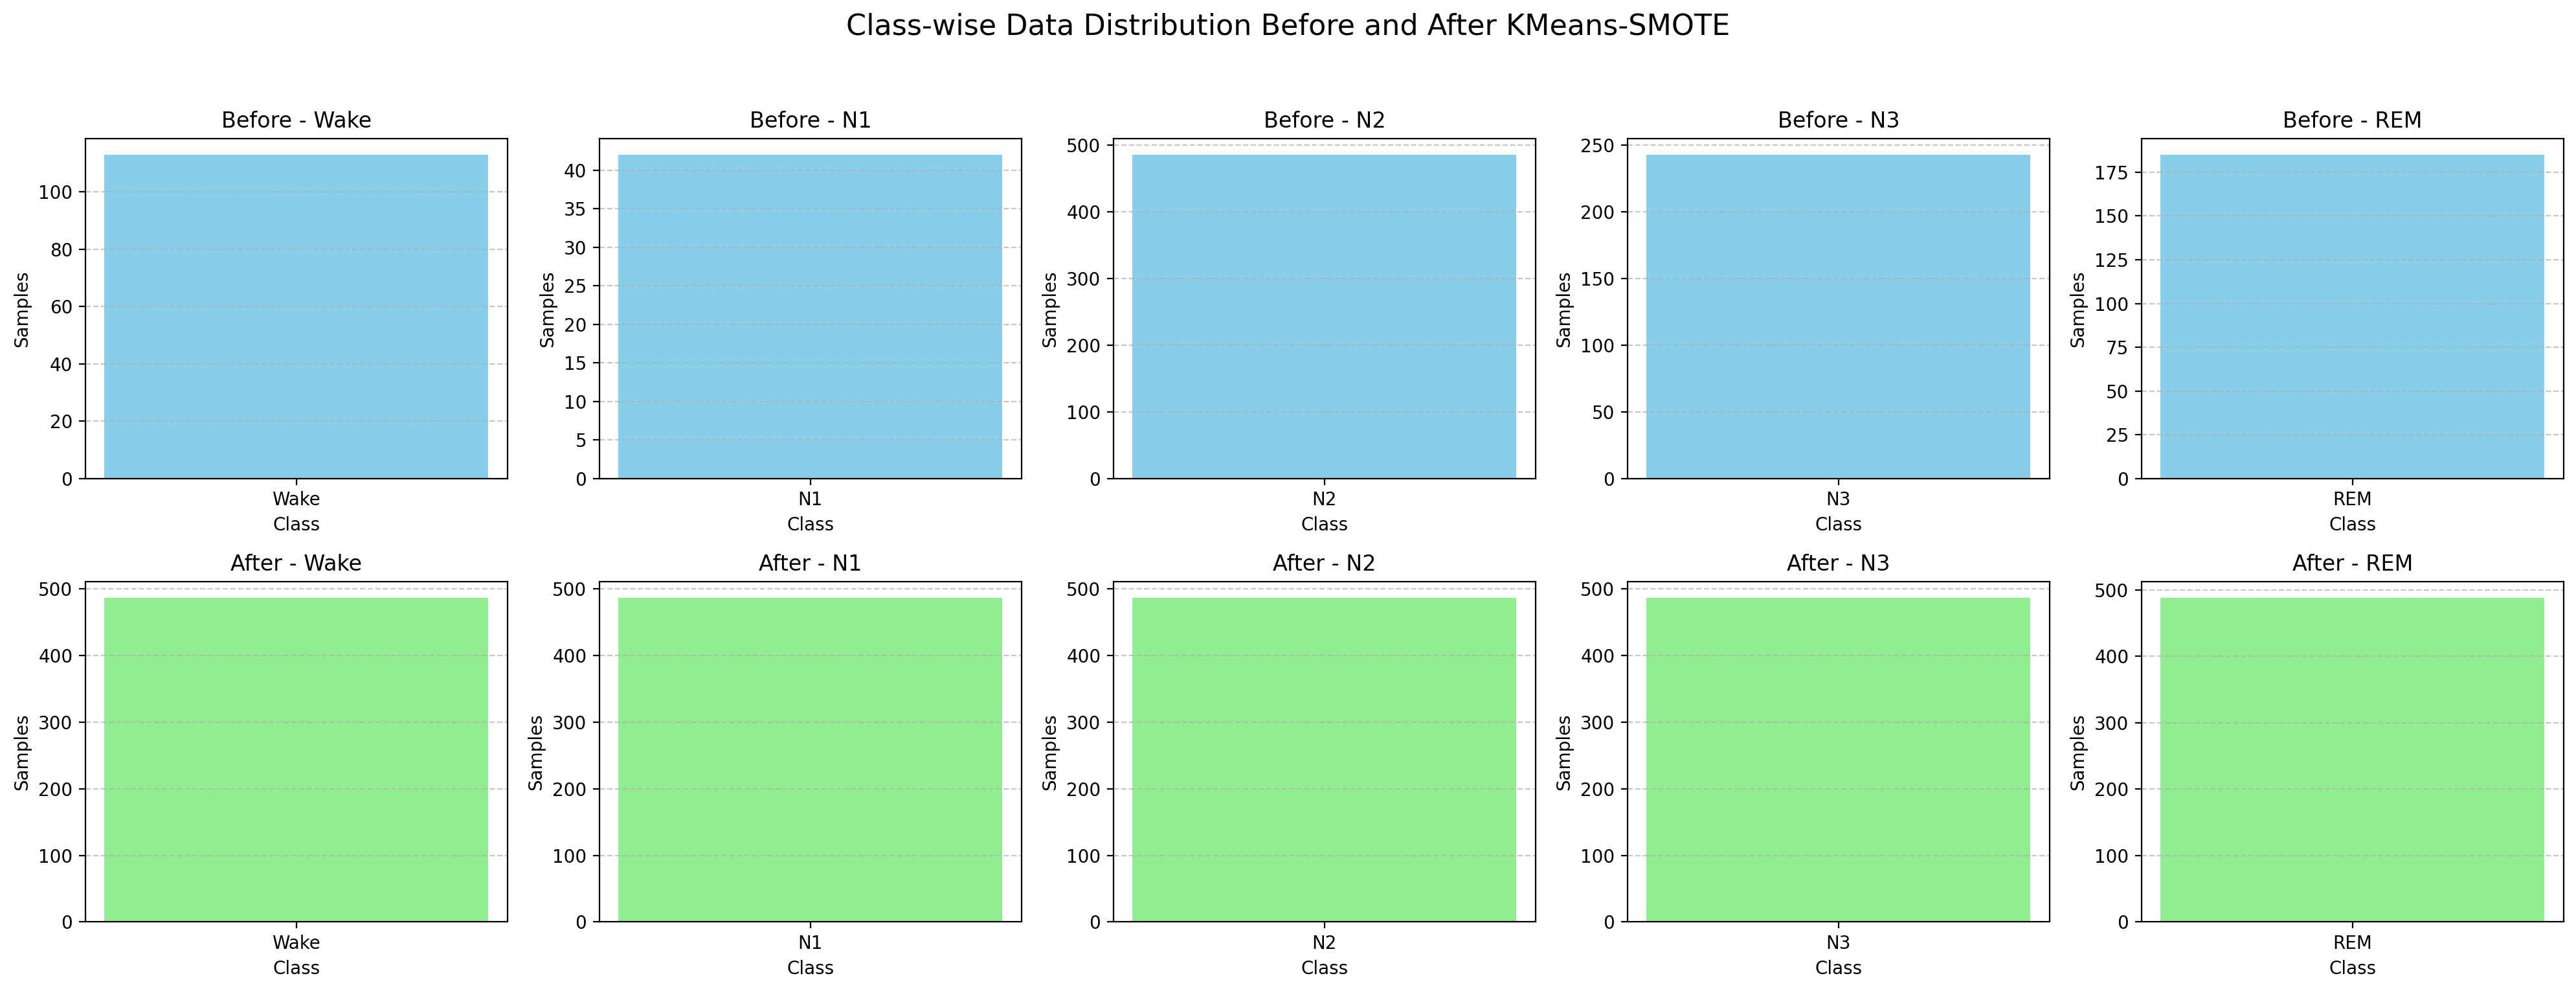

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Data counts before balancing
before_counts = {
    'Wake': 113,
    'N1': 42,
    'N2': 486,
    'N3': 243,
    'REM': 185
}

# Load balanced dataset
directory = '/content/drive/MyDrive/Extracted-features'
balanced_file_path = os.path.join(directory, 'balanced_dataset.csv')
balanced_df = pd.read_csv(balanced_file_path)

# Data counts after balancing
after_counts = balanced_df['label'].value_counts().sort_index().to_dict()

# Class label mapping
class_labels = ['Wake', 'N1', 'N2', 'N3', 'REM']

# Create a 2x5 subplot figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=200)
fig.suptitle('Class-wise Data Distribution Before and After KMeans-SMOTE', fontsize=16)

# Plot before balancing (first row)
for i, label in enumerate(class_labels):
    ax = axes[0, i]
    ax.bar(label, before_counts[label], color='skyblue')
    ax.set_title(f'Before - {label}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Samples')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Plot after balancing (second row)
for i, label in enumerate(class_labels):
    ax = axes[1, i]
    count = after_counts.get(i, 0)  # label index from 0-4
    ax.bar(label, count, color='lightgreen')
    ax.set_title(f'After - {label}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Samples')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path = os.path.join(directory, 'classwise_distribution_before_after.png')
plt.savefig(plot_path, dpi=300)
plt.show()



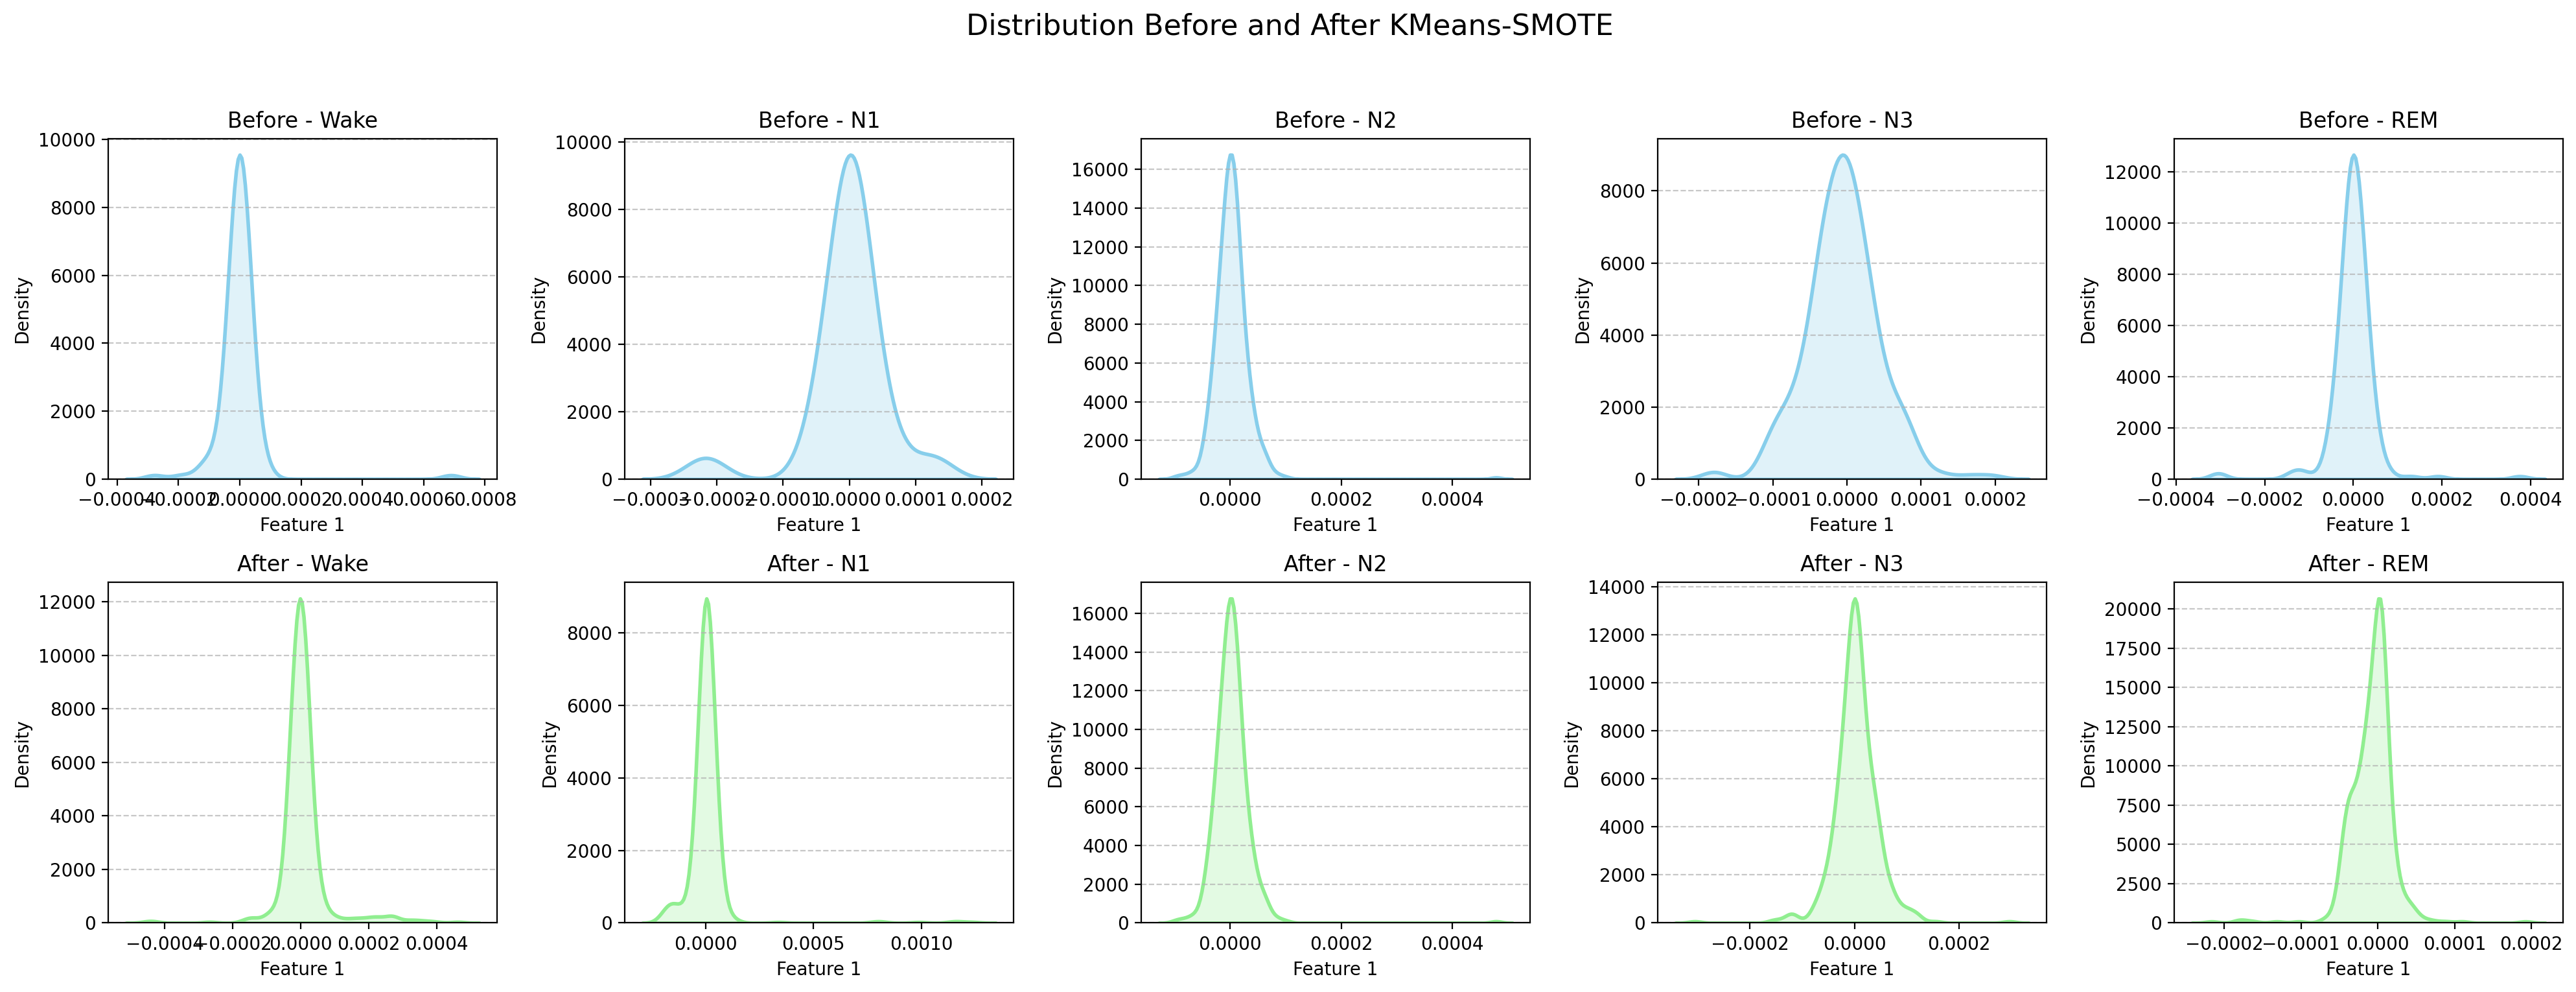

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory
directory = '/content/drive/MyDrive/Extracted-features'

# Load original CSV files before balancing
before_files = {
    'Wake': '1018_8320_EOG-ROC-M1_wake_stage.csv',
    'N1': '1018_8320_EOG-ROC-M1_N1_stage.csv',
    'N2': '1018_8320_EOG-ROC-M1_N2_stage.csv',
    'N3': '1018_8320_EOG-ROC-M1_N3_stage.csv',
    'REM': '1018_8320_EOG-ROC-M1_Rem_stage.csv'
}

# Load data for before balancing
before_data = {}
for label, filename in before_files.items():
    path = os.path.join(directory, filename)
    df = pd.read_csv(path)
    # Use a sample feature (e.g., the first column) to represent distribution
    before_data[label] = df.iloc[:, 0]

# Load balanced dataset
balanced_df = pd.read_csv(os.path.join(directory, 'balanced_dataset.csv'))

# Class label mapping (index to name)
class_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

# Create a 2x5 subplot figure for bell-shaped KDE plots
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=200)
fig.suptitle('Distribution Before and After KMeans-SMOTE', fontsize=16)

# Plot before balancing (first row)
for i, label in enumerate(class_labels.values()):
    ax = axes[0, i]
    sns.kdeplot(before_data[label], fill=True, color='skyblue', ax=ax, linewidth=2)
    ax.set_title(f'Before - {label}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Density')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Plot after balancing (second row)
for i, idx in enumerate(class_labels.keys()):
    ax = axes[1, i]
    # Filter balanced dataset for current class
    data = balanced_df[balanced_df['label'] == idx].iloc[:, 0]
    sns.kdeplot(data, fill=True, color='lightgreen', ax=ax, linewidth=2)
    ax.set_title(f'After - {class_labels[idx]}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Density')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path = os.path.join(directory, 'bell_shaped_distribution_before_after.png')
plt.savefig(plot_path, dpi=300)
plt.show()



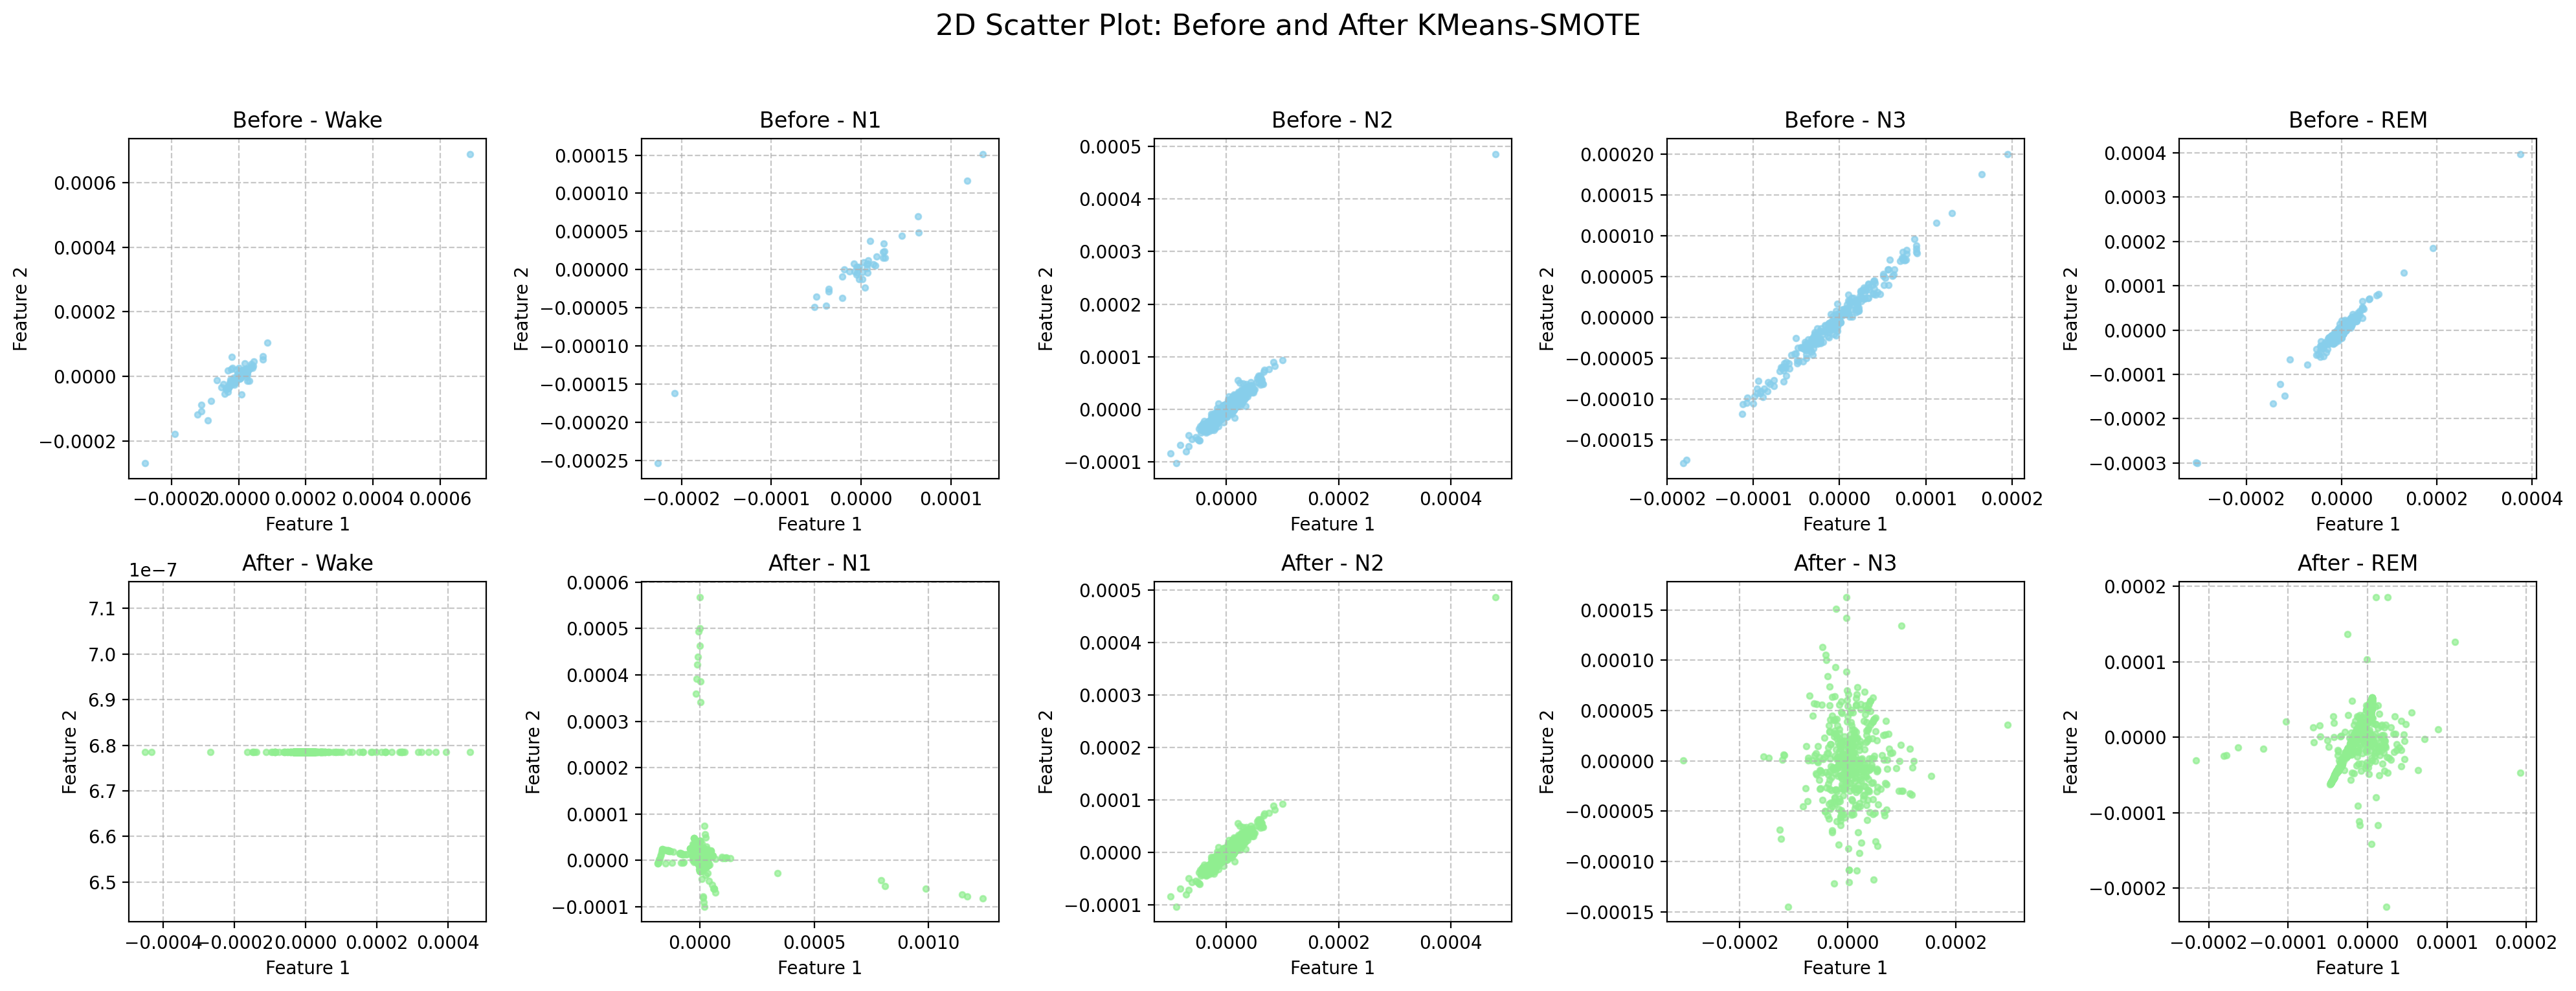

✅ Scatter plot distribution saved: /content/drive/MyDrive/Extracted-features/scatter_distribution_before_after.png


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory
directory = '/content/drive/MyDrive/Extracted-features'

# Load original CSV files before balancing
before_files = {
    'Wake': '1018_8320_EOG-ROC-M1_wake_stage.csv',
    'N1': '1018_8320_EOG-ROC-M1_N1_stage.csv',
    'N2': '1018_8320_EOG-ROC-M1_N2_stage.csv',
    'N3': '1018_8320_EOG-ROC-M1_N3_stage.csv',
    'REM': '1018_8320_EOG-ROC-M1_Rem_stage.csv'
}

# Load data for before balancing
before_data = {}
for label, filename in before_files.items():
    path = os.path.join(directory, filename)
    df = pd.read_csv(path)
    # Use first two features for scatter plots
    before_data[label] = df.iloc[:, :2]

# Load balanced dataset
balanced_df = pd.read_csv(os.path.join(directory, 'balanced_dataset.csv'))

# Class label mapping (index to name)
class_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

# Create 2x5 subplot figure
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=200)
fig.suptitle('2Before and After KMeans-SMOTE', fontsize=16)

# Plot before balancing (first row)
for i, label in enumerate(class_labels.values()):
    ax = axes[0, i]
    data = before_data[label]
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], s=10, alpha=0.7, color='skyblue')
    ax.set_title(f'Before - {label}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, linestyle='--', alpha=0.7)

# Plot after balancing (second row)
for i, idx in enumerate(class_labels.keys()):
    ax = axes[1, i]
    data = balanced_df[balanced_df['label'] == idx].iloc[:, :2]
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], s=10, alpha=0.7, color='lightgreen')
    ax.set_title(f'After - {class_labels[idx]}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path = os.path.join(directory, 'scatter_distribution_before_after.png')
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"✅ Scatter plot distribution saved: {plot_path}")


# **Feature Selection**

Paper:
Improved Relief Weight Feature Selection Algorithm Based on Relief and Mutual Information
🟢 Combines ReliefF (neighbor-based feature ranking) with mutual information, especially good for biomedical data.
🟢 Faster and more robust than traditional ReliefF/MI-based methods.

In [ ]:
!pip install skrebate


  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=15a9fc4d2219d7a1d9a6bf432cc30d8b866e9f7ff7a10c7f73dd1cd09f13670d
  Stored in directory: /root/.cache/pip/wheels/8a/d2/67/8368fca718041057b33d6448ca526aaf1ce2e404c94b901e41
Successfully built skrebate


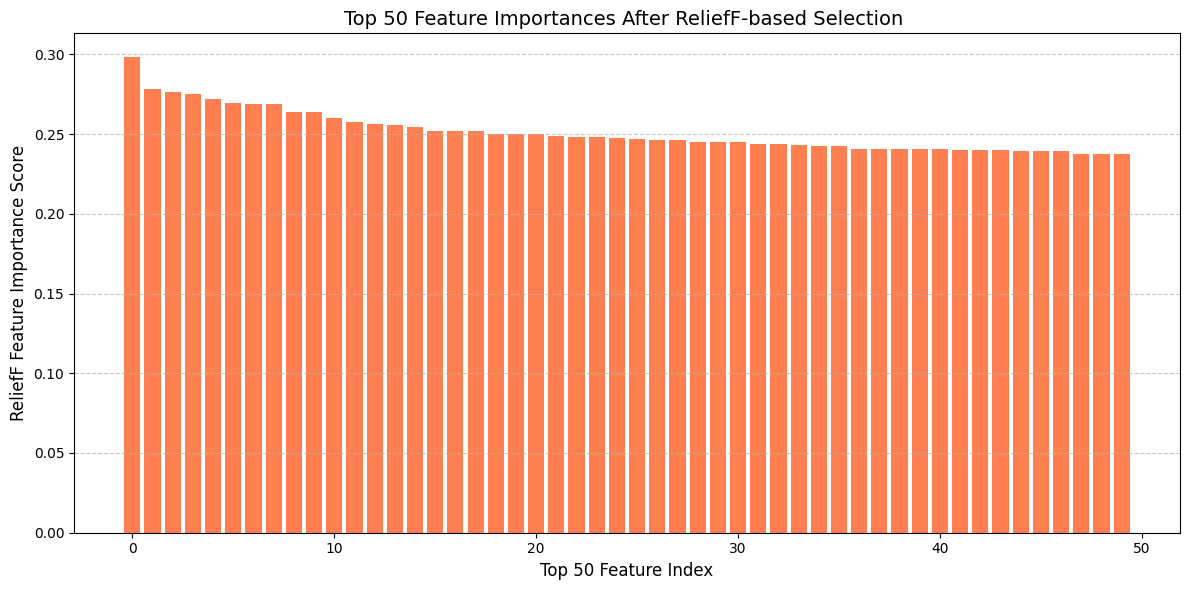

<ipython-input-2-5190f84ad596>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_df['label'] = y


Feature selection execution time: 6524.51 seconds
Top 50 feature dataset saved: /content/drive/MyDrive/Extracted-features/balanced_top50_features.csv
Top 50 feature indices: [ 8957 10064  9521  9523  9644  8956  9780  9522  8959  9572  9451  9650
 10070  9534  9649  9007  9647  9438  9783  9520  9467  9571  8205  9722
  9006  9216  9525  9579  9723  9576  7793  9536  9342  9643  9575  9465
  9779  9776  9019  9569  3228  9765  9468  4983  9466  9511  9777  9786
  8958  9724]


In [ ]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from skrebate import ReliefF

# Record the start time
start_time = time.time()

# Load the balanced dataset
directory = '/content/drive/MyDrive/Extracted-features'
balanced_file_path = f'{directory}/balanced_dataset.csv'
df = pd.read_csv(balanced_file_path)

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Apply ReliefF for feature selection
relief = ReliefF(n_neighbors=10, n_features_to_select=50)  # Select top 50 features
relief.fit(X.values, y.values)

# Get feature scores and indices
feature_scores = relief.feature_importances_
top_features_indices = feature_scores.argsort()[-50:][::-1]

# Plot top feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(50), feature_scores[top_features_indices], color='coral')
plt.xlabel('Top 50 Feature Index', fontsize=12)
plt.ylabel('ReliefF Feature Importance Score', fontsize=12)
plt.title('Top 50 Feature Importances After ReliefF-based Selection ', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save top features to a new CSV file
top_features_df = X.iloc[:, top_features_indices]
top_features_df['label'] = y
top_features_file_path = f'{directory}/balanced_top50_features.csv'
top_features_df.to_csv(top_features_file_path, index=False)

# Record the end time
end_time = time.time()
execution_time = end_time - start_time

# Timing and summary
print(f"Feature selection execution time: {execution_time:.2f} seconds")
print(f"Top 50 feature dataset saved: {top_features_file_path}")
print(f"Top 50 feature indices: {top_features_indices}")


# **Ante hoc models**

In [ ]:
pip install interpret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 17.5 MB/s eta 0:00:00
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.2-py3-none-any.whl size=401

In [ ]:
pip install skope-rules

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 924.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8df6bbcb908d3ae5765aac815719931b638605a00f57f041b3c38837dac65403
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lime
import lime.lime_tabular

# Simulated implementation for Naive Discriminant Classifier (NDC)
class NaiveDiscriminantClassifier:
    def __init__(self):
        self.model = LogisticRegression(max_iter=1000)
    def fit(self, X, y):
        self.model.fit(X, y)
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Load dataset
directory = '/content/drive/MyDrive/Extracted-features'
feature_file_path = f'{directory}/balanced_top50_features.csv'
df = pd.read_csv(feature_file_path)

X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models to train (without SkopeRules)
models = {
    'LDA': LDA(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'EBM': ExplainableBoostingClassifier(random_state=42),
    'NDC': NaiveDiscriminantClassifier()
}

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'TP', 'TN', 'FP', 'FN'])
timing_df = pd.DataFrame(columns=['Model', 'Train Time (s)', 'Test Time (s)', 'Prediction Time (s)'])

best_model_name = None
best_model_score = 0
best_model = None

for name, model in models.items():
    print(f"Training model: {name}")

    train_start = time.time()
    model.fit(X_train, y_train)
    train_end = time.time()
    train_time = train_end - train_start

    test_start = time.time()
    y_pred = model.predict(X_test)
    test_end = time.time()
    test_time = test_end - test_start

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Model': [name],
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1': [f1],
        'TP': [tp],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn]
    })], ignore_index=True)

    timing_df = pd.concat([timing_df, pd.DataFrame({
        'Model': [name],
        'Train Time (s)': [train_time],
        'Test Time (s)': [test_time],
        'Prediction Time (s)': [test_time]
    })], ignore_index=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{directory}/confusion_matrix_{name}.png')
    plt.close()

    if acc > best_model_score:
        best_model_score = acc
        best_model_name = name
        best_model = model

metrics_df.to_csv(f'{directory}/model_metrics.csv', index=False)
timing_df.to_csv(f'{directory}/model_timings.csv', index=False)

print(f"\nBest-performing model: {best_model_name} with Accuracy: {best_model_score:.4f}")

# Apply LIME on best model
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Wake', 'N1', 'N2', 'N3', 'REM'],
    mode='classification'
)
sample_idx = 0
exp = explainer.explain_instance(X_test.iloc[sample_idx], best_model.predict_proba, num_features=10)

lime_features = dict(exp.as_list())
lime_df = pd.DataFrame(list(lime_features.items()), columns=['Feature', 'Score'])
lime_df.to_csv(f'{directory}/LIME_feature_importance_{best_model_name}.csv', index=False)

fig = exp.as_pyplot_figure()
plt.title(f'LIME Explanation - {best_model_name} - Sample {sample_idx}')
plt.tight_layout()
plt.savefig(f'{directory}/LIME_explanation_{best_model_name}.png')
plt.close()

print(f"✅ LIME explanation saved for {best_model_name}!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Extracted-features/balanced_top50_features.csv'

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import SVC

# Load PCA dataset
directory = '/content/drive/MyDrive/Extracted-features'
pca_file_path = f'{directory}/balanced_top50_features.csv'
df = pd.read_csv(pca_file_path)

X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models to train
models = {
    'Bagging': BaggingClassifier(n_estimators=100, random_state=42),
    'Stacking': StackingClassifier(
        estimators=[('lr', LogisticRegression(max_iter=1000)), ('svc', SVC(kernel='linear', probability=True))],
        final_estimator=LogisticRegression(max_iter=1000)
    ),
    'ELM_Approx': RidgeClassifier(),
    'RidgeClassifier': RidgeClassifier(),
    'PassiveAggressive': PassiveAggressiveClassifier(max_iter=1000, random_state=42)
}

# Metrics storage
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
timing_df = pd.DataFrame(columns=['Model', 'Train Time (s)', 'Test Time (s)'])

for name, model in models.items():
    print(f"Training model: {name}")

    train_start = time.time()
    model.fit(X_train, y_train)
    train_end = time.time()
    train_time = train_end - train_start

    test_start = time.time()
    y_pred = model.predict(X_test)
    test_end = time.time()
    test_time = test_end - test_start

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store metrics
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }])], ignore_index=True)

    timing_df = pd.concat([timing_df, pd.DataFrame([{
        'Model': name,
        'Train Time (s)': train_time,
        'Test Time (s)': test_time
    }])], ignore_index=True)

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{directory}/confusion_matrix_fsa_{name}.png')
    plt.close()

# Save metrics and timings
metrics_file = f'{directory}/posthoc_fs_model_metrics.csv'
timing_file = f'{directory}/posthoc_fs_model_timings.csv'
metrics_df.to_csv(metrics_file, index=False)
timing_df.to_csv(timing_file, index=False)

print(f"✅ Metrics saved: {metrics_file}")
print(f"✅ Timings saved: {timing_file}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Extracted-features/balanced_top50_features.csv'

# **Post**

**PCA**

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the original balanced file (not top 50 features)
directory = '/content/drive/MyDrive/Extracted-features'
balanced_file_path = f'{directory}/balanced_dataset.csv'
df = pd.read_csv(balanced_file_path)

# Separate features and label
X = df.drop(columns=['label'])
y = df['label']

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA features
pca_features_df = pd.DataFrame(X_pca)
pca_features_df['label'] = y.values

# Save the PCA features to a new CSV file
pca_file_path = f'{directory}/balanced_dataset_PCA.csv'
pca_features_df.to_csv(pca_file_path, index=False)

# Display the first few rows of the PCA dataset and the saved path
pca_features_df.head(), pca_file_path


(           0         1         2         3         4         5         6  \
 0   9.503208 -2.594221 -4.980919 -3.108045  1.505096 -2.309315 -0.138575   
 1  11.627177  2.037116 -3.453829  1.616662  0.175562  1.850628  0.479317   
 2  10.536966  0.881500 -2.330689  0.370740 -0.343627 -0.989747  2.092057   
 3  10.002622 -0.970647 -4.403354 -5.348249  0.346129  1.890135  0.951904   
 4  11.820992  0.538435 -3.324585 -2.544489  0.342373  1.195917  0.374342   
 
           7         8         9  ...       345       346       347       348  \
 0  5.066867 -0.794753  1.453713  ...  2.213165 -2.275920 -2.238687  1.735364   
 1  0.815921 -0.230072  1.182229  ... -0.592495 -2.049400  5.380861 -1.128743   
 2  4.090190 -0.412048 -3.415122  ...  2.073613 -0.506740 -8.737090  3.373997   
 3  4.298902 -0.518221 -1.007133  ...  1.106211 -1.589568 -3.066264 -1.557424   
 4  3.472727  0.219928 -1.647347  ... -0.026098  2.403503  2.684707  1.233392   
 
         349       350       351       352      

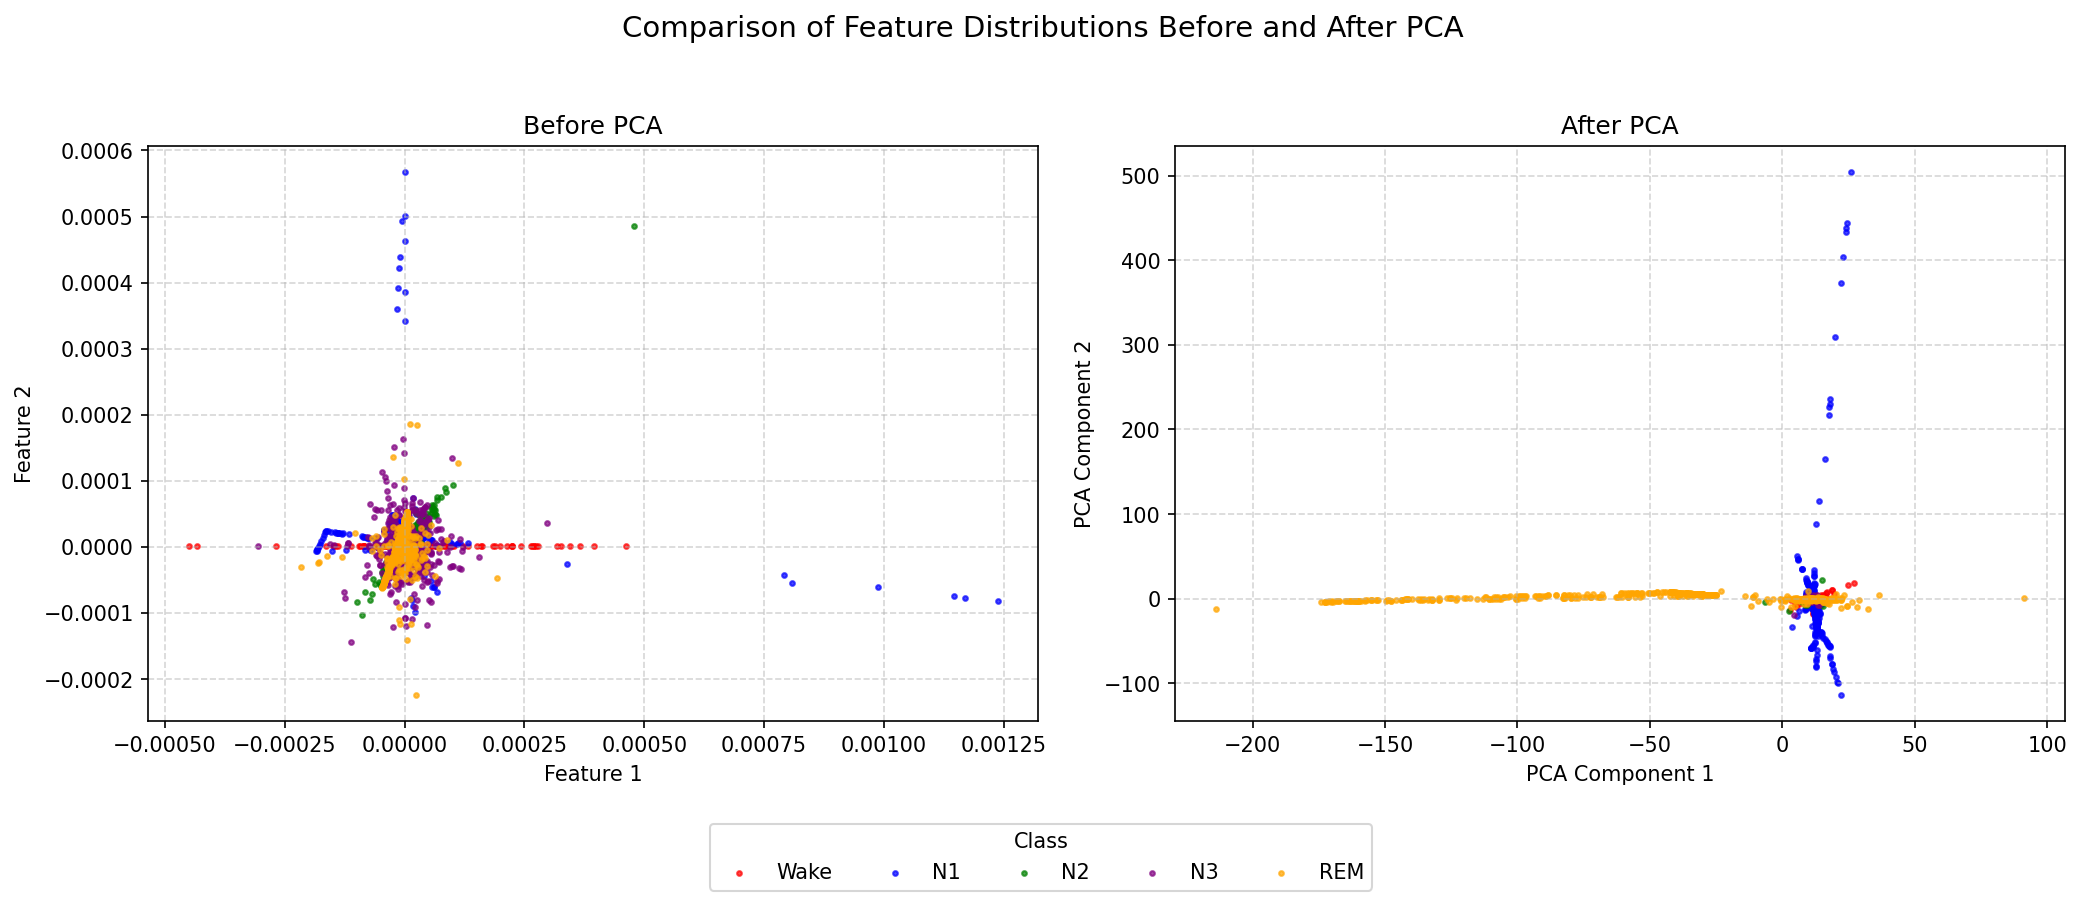

✅ Scatter plot with shared legend saved: /content/drive/MyDrive/Extracted-features/Results-PCA/scatter_before_after_PCA.png
✅ PCA features saved: /content/drive/MyDrive/Extracted-features/Results-PCA/balanced_dataset_PCA.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the balanced dataset
directory = '/content/drive/MyDrive/Extracted-features'
results_directory = f'{directory}/Results-PCA'
balanced_file_path = f'{directory}/Balanced/balanced_dataset.csv'
df = pd.read_csv(balanced_file_path)

# Separate features and label
X = df.drop(columns=['label'])
y = df['label']

# Class label mapping
class_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_scaled)

# Create 1x2 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# Scatter plots
for label, color in zip(class_labels, colors):
    mask = y == label
    axes[0].scatter(X.loc[mask, X.columns[0]], X.loc[mask, X.columns[1]],
                     label=class_labels[label], s=5, alpha=0.7, color=color)
    axes[1].scatter(X_pca_vis[mask, 0], X_pca_vis[mask, 1],
                     label=class_labels[label], s=5, alpha=0.7, color=color)

axes[0].set_title('Before PCA')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].set_title('After PCA')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Class', loc='lower center', ncol=5, fontsize=10)

plt.suptitle('Comparison of Feature Distributions Before and After PCA', fontsize=14)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Save combined figure in Results-PCA directory
combined_plot_path = f'{results_directory}/scatter_before_after_PCA.png'
plt.savefig(combined_plot_path, dpi=300)
plt.show()

# Save PCA features for training
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_features_df = pd.DataFrame(X_pca)
pca_features_df['label'] = y.values
pca_file_path = f'{results_directory}/balanced_dataset_PCA.csv'
pca_features_df.to_csv(pca_file_path, index=False)

print(f"✅ Scatter plot with shared legend saved: {combined_plot_path}")
print(f"✅ PCA features saved: {pca_file_path}")


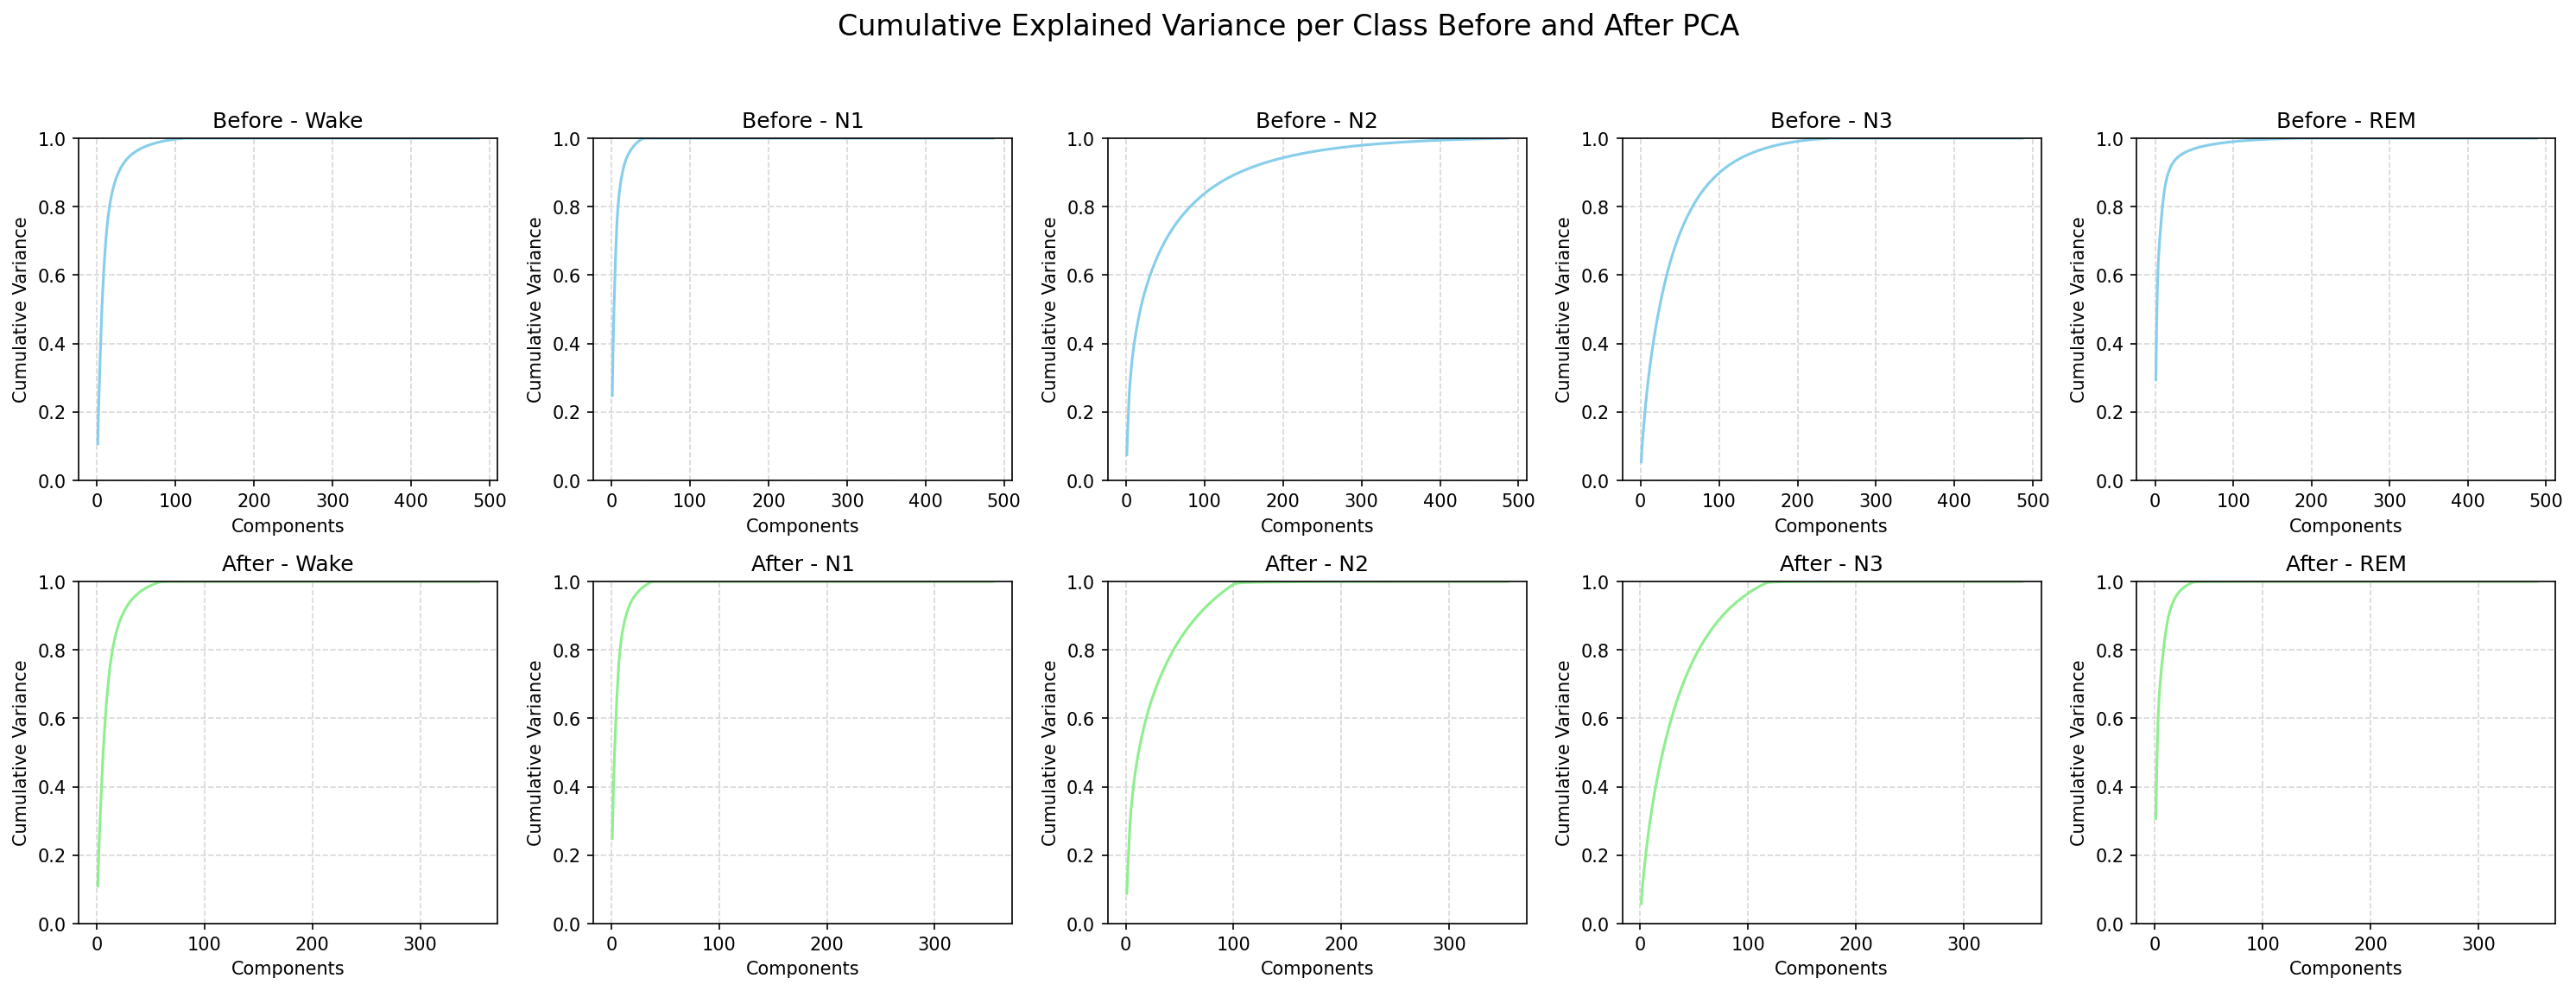

'/content/drive/MyDrive/Extracted-features/Results-PCA/cumulative_explained_variance.png'

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Paths
directory = '/content/drive/MyDrive/Extracted-features'
results_directory = f'{directory}/Results-PCA'
balanced_file_path = f'{directory}/Balanced/balanced_dataset.csv'

# Load the dataset
df = pd.read_csv(balanced_file_path)
X = df.drop(columns=['label'])
y = df['label']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Class label mapping
class_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

# Create 2x5 subplots for cumulative explained variance
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=150)
fig.suptitle('Cumulative Explained Variance per Class Before and After PCA', fontsize=16)

# Before PCA cumulative variance plots (original data)
for i, label in enumerate(class_labels):
    ax = axes[0, i]
    class_data = X_scaled[y == label]
    pca_before = PCA()
    pca_before.fit(class_data)
    cum_var_before = pca_before.explained_variance_ratio_.cumsum()
    ax.plot(range(1, len(cum_var_before) + 1), cum_var_before, color='skyblue')
    ax.set_title(f'Before - {class_labels[label]}')
    ax.set_xlabel('Components')
    ax.set_ylabel('Cumulative Variance')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(0, 1)

# After PCA cumulative variance plots (PCA-reduced data)
pca_global = PCA(n_components=0.95, random_state=42)
X_pca = pca_global.fit_transform(X_scaled)

for i, label in enumerate(class_labels):
    ax = axes[1, i]
    class_data_pca = X_pca[y == label]
    pca_after = PCA()
    pca_after.fit(class_data_pca)
    cum_var_after = pca_after.explained_variance_ratio_.cumsum()
    ax.plot(range(1, len(cum_var_after) + 1), cum_var_after, color='lightgreen')
    ax.set_title(f'After - {class_labels[label]}')
    ax.set_xlabel('Components')
    ax.set_ylabel('Cumulative Variance')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(0, 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path = f'{results_directory}/cumulative_explained_variance.png'
plt.savefig(plot_path, dpi=300)
plt.show()

plot_path


<ipython-input-16-5c9a2ba836ba>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=before_melt, x='Feature', y='Value', inner='quart', palette=palette, ax=axes[0])
<ipython-input-16-5c9a2ba836ba>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=after_melt, x='Feature', y='Value', inner='quart', palette=palette, ax=axes[1])


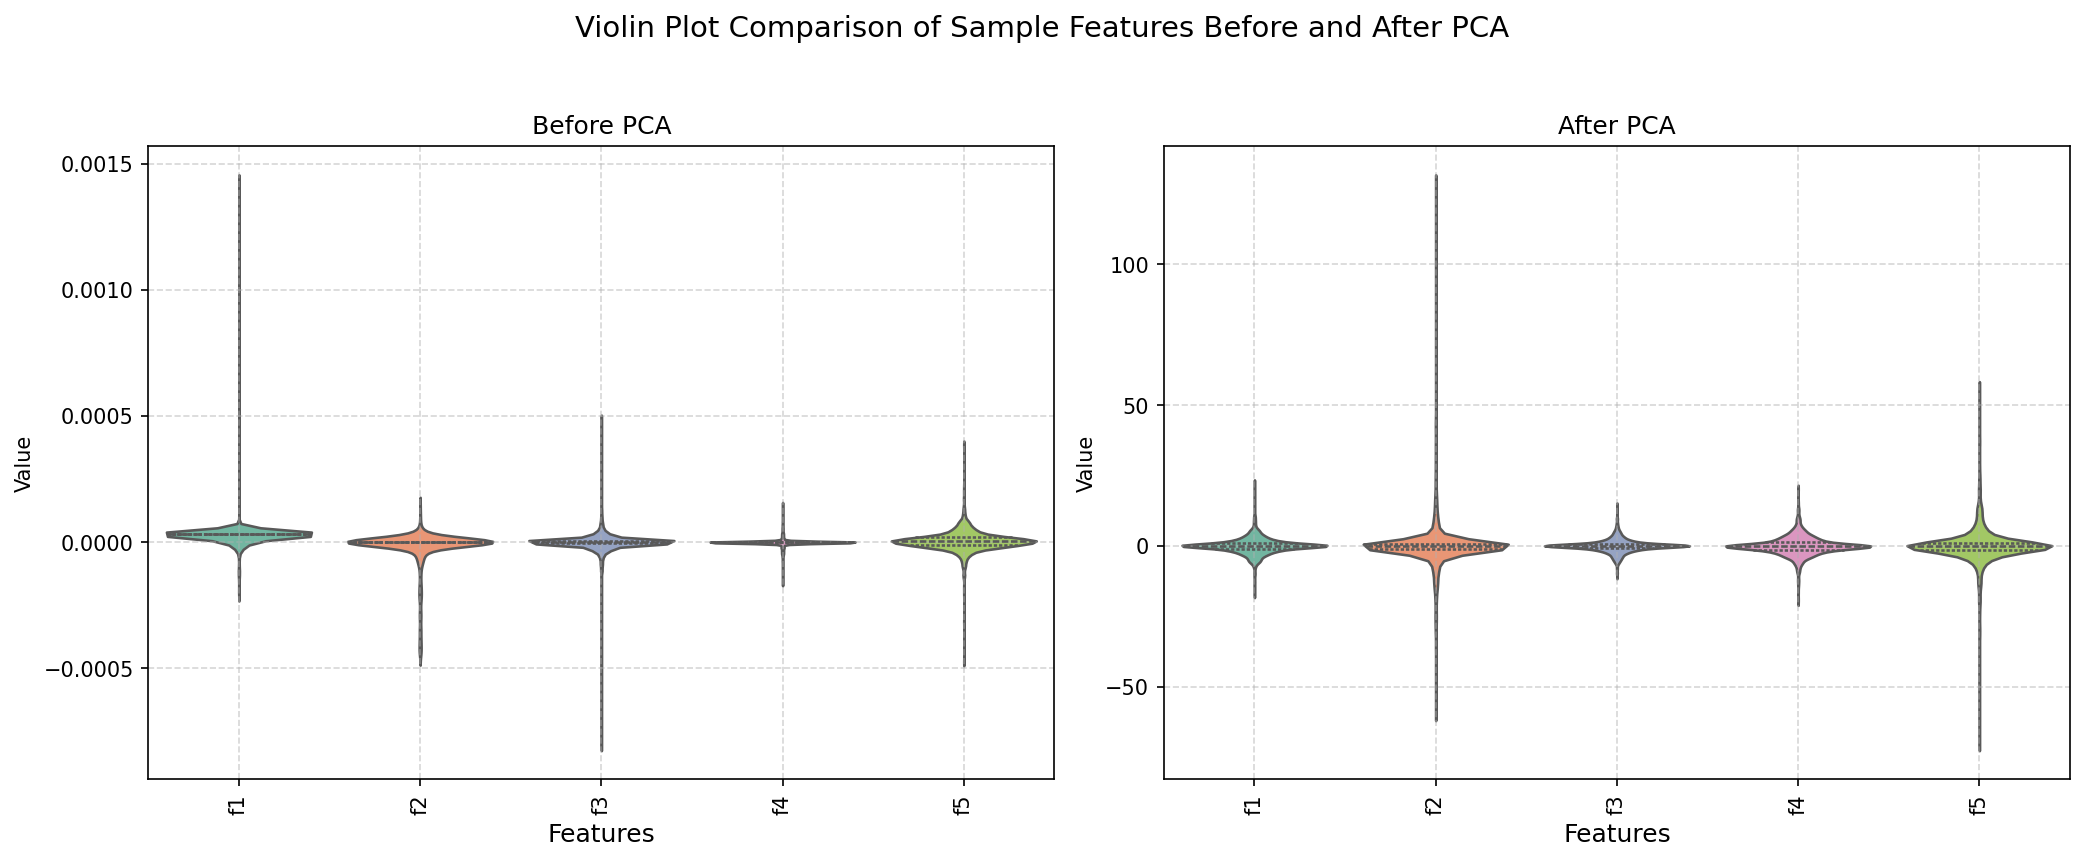

✅ Violin plot saved: /content/drive/MyDrive/Extracted-features/Results-PCA/violin_plot_comparison_features_labeled.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Correct paths
directory = '/content/drive/MyDrive/Extracted-features'
before_file = f'{directory}/Balanced/balanced_dataset.csv'
after_file = f'{directory}/Balanced/balanced_dataset_PCA.csv'

# Load datasets
before_df = pd.read_csv(before_file).drop(columns=['label'])
after_df = pd.read_csv(after_file).drop(columns=['label'])

# Randomly select a few features for easier visualization
sample_features_before = before_df.sample(n=5, axis=1, random_state=42)
sample_features_after = after_df.sample(n=5, axis=1, random_state=42)

# Rename columns to f1, f2, f3, f4, f5 for consistency
feature_labels = [f'f{i+1}' for i in range(sample_features_before.shape[1])]
sample_features_before.columns = feature_labels
sample_features_after.columns = feature_labels

# Melt data for seaborn violin plot
before_melt = sample_features_before.melt(var_name='Feature', value_name='Value')
before_melt['Dataset'] = 'Before PCA'

after_melt = sample_features_after.melt(var_name='Feature', value_name='Value')
after_melt['Dataset'] = 'After PCA'

# Create 1x2 subplot figure for violin plots with each feature colored differently
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# Color palette for different features
palette = sns.color_palette('Set2', n_colors=5)

# Before PCA violin plots
sns.violinplot(data=before_melt, x='Feature', y='Value', inner='quart', palette=palette, ax=axes[0])
axes[0].set_title('Before PCA')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_xlabel('Features', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# After PCA violin plots
sns.violinplot(data=after_melt, x='Feature', y='Value', inner='quart', palette=palette, ax=axes[1])
axes[1].set_title('After PCA')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_xlabel('Features', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

plt.suptitle('Violin Plot Comparison of Sample Features Before and After PCA', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save plot
violin_plot_path = f'{directory}/Results-PCA/violin_plot_comparison_features_labeled.png'
plt.savefig(violin_plot_path, dpi=300)
plt.show()

print(f"✅ Violin plot saved: {violin_plot_path}")


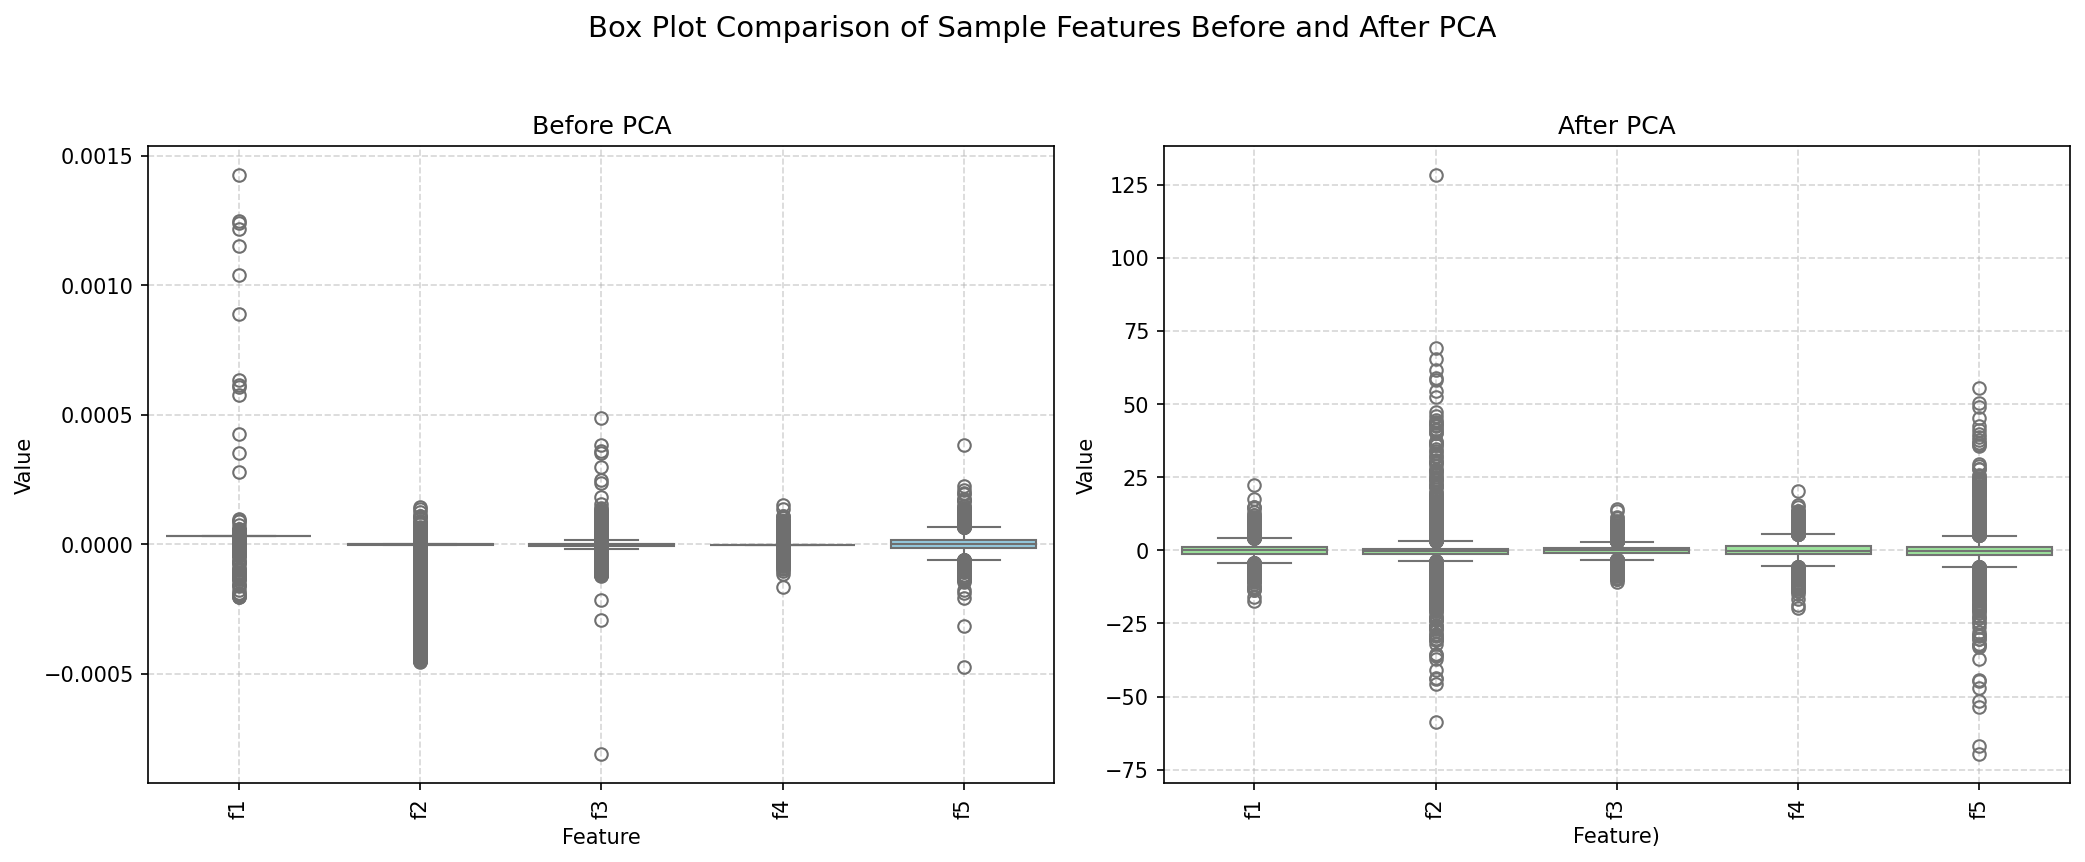

'/content/drive/MyDrive/Extracted-features/Results-PCA/box_plot_comparison_features_labeled.png'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

directory = '/content/drive/MyDrive/Extracted-features'
before_file = f'{directory}/Balanced/balanced_dataset.csv'
after_file = f'{directory}/Balanced/balanced_dataset_PCA.csv'

# Load datasets
before_df = pd.read_csv(before_file).drop(columns=['label'])
after_df = pd.read_csv(after_file).drop(columns=['label'])

# Randomly select a few features for easier visualization
sample_features_before = before_df.sample(n=5, axis=1, random_state=42)
sample_features_after = after_df.sample(n=5, axis=1, random_state=42)

# Rename columns to f1, f2, f3, f4, f5 for consistency
sample_features_before.columns = [f'f{i+1}' for i in range(sample_features_before.shape[1])]
sample_features_after.columns = [f'f{i+1}' for i in range(sample_features_after.shape[1])]

# Melt data for seaborn boxplot
before_melt = sample_features_before.melt(var_name='Feature', value_name='Value')
before_melt['Dataset'] = 'Before PCA'

after_melt = sample_features_after.melt(var_name='Feature', value_name='Value')
after_melt['Dataset'] = 'After PCA'

# Combine melted data
combined = pd.concat([before_melt, after_melt])

# Create 1x2 subplot figure for box plot only
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# Box plots with rotated x-axis labels (90 degrees) and renamed features
sns.boxplot(data=before_melt, x='Feature', y='Value', color='skyblue', ax=axes[0])
axes[0].set_title('Before PCA')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_xlabel('Feature')
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=after_melt, x='Feature', y='Value', color='lightgreen', ax=axes[1])
axes[1].set_title('After PCA')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_xlabel('Feature)')
axes[1].tick_params(axis='x', rotation=90)

plt.suptitle('Box Plot Comparison of Sample Features Before and After PCA', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save plot
box_plot_path = f'{directory}/Results-PCA/box_plot_comparison_features_labeled.png'
plt.savefig(box_plot_path, dpi=300)
plt.show()

box_plot_path


# **Ante**

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lime
import lime.lime_tabular

# Simulated implementation for Naive Discriminant Classifier (NDC)
class NaiveDiscriminantClassifier:
    def __init__(self):
        self.model = LogisticRegression(max_iter=1000)
    def fit(self, X, y):
        self.model.fit(X, y)
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Load dataset
directory = '/content/drive/MyDrive/Extracted-features/Balanced'
feature_file_path = f'{directory}/balanced_dataset_PCA.csv'
ouputdirectory = '/content/drive/MyDrive/Extracted-features/Ante'
df = pd.read_csv(feature_file_path)

X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models to train (without SkopeRules)
models = {
    'LDA': LDA(),
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'EBM': ExplainableBoostingClassifier(random_state=42),
    'NDC': NaiveDiscriminantClassifier()
}

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'TP', 'TN', 'FP', 'FN'])
timing_df = pd.DataFrame(columns=['Model', 'Train Time (s)', 'Test Time (s)', 'Prediction Time (s)'])

best_model_name = None
best_model_score = 0
best_model = None

for name, model in models.items():
    print(f"Training model: {name}")

    train_start = time.time()
    model.fit(X_train, y_train)
    train_end = time.time()
    train_time = train_end - train_start

    test_start = time.time()
    y_pred = model.predict(X_test)
    test_end = time.time()
    test_time = test_end - test_start

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Model': [name],
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1': [f1],
        'TP': [tp],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn]
    })], ignore_index=True)

    timing_df = pd.concat([timing_df, pd.DataFrame({
        'Model': [name],
        'Train Time (s)': [train_time],
        'Test Time (s)': [test_time],
        'Prediction Time (s)': [test_time]
    })], ignore_index=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{ouputdirectory}/confusion_matrix_pca_{name}.png')
    plt.close()

    if acc > best_model_score:
        best_model_score = acc
        best_model_name = name
        best_model = model

metrics_df.to_csv(f'{ouputdirectory}/model_metrics_pca.csv', index=False)
timing_df.to_csv(f'{ouputdirectory}/model_timings_pca.csv', index=False)

print(f"\nBest-performing model: {best_model_name} with Accuracy: {best_model_score:.4f}")

# Apply LIME on best model
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Wake', 'N1', 'N2', 'N3', 'REM'],
    mode='classification'
)
sample_idx = 0
exp = explainer.explain_instance(X_test.iloc[sample_idx], best_model.predict_proba, num_features=10)

lime_features = dict(exp.as_list())
lime_df = pd.DataFrame(list(lime_features.items()), columns=['Feature', 'Score'])
lime_df.to_csv(f'{ouputdirectory}/LIME_feature_importance_{best_model_name}.csv', index=False)

fig = exp.as_pyplot_figure()
plt.title(f'LIME Explanation - {best_model_name} - Sample {sample_idx}')
plt.tight_layout()
plt.savefig(f'{ouputdirectory}/LIME_explanation_{best_model_name}.png')
plt.close()

print(f"✅ LIME explanation saved for {best_model_name}!")


Training model: LDA


/tmp/ipython-input-8-4115159347.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({
/tmp/ipython-input-8-4115159347.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  timing_df = pd.concat([timing_df, pd.DataFrame({


Training model: DecisionTree
Training model: EBM


/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:1249: UserWarning: For multiclass we cannot currently visualize pairs and they will be stripped from the global explanations. Set interactions=0 to generate a fully interpretable glassbox model.
  warn(


# **Post**

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import SVC

# Load PCA dataset
directory = '/content/drive/MyDrive/Extracted-features/Balanced'
pca_file_path = f'{directory}/balanced_dataset_PCA.csv'
ouputdirectory = '/content/drive/MyDrive/Extracted-features/Post'
df = pd.read_csv(pca_file_path)

X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models to train
models = {
    'Bagging': BaggingClassifier(n_estimators=100, random_state=42),
    'Stacking': StackingClassifier(
        estimators=[('lr', LogisticRegression(max_iter=1000)), ('svc', SVC(kernel='linear', probability=True))],
        final_estimator=LogisticRegression(max_iter=1000)
    ),
    'ELM_Approx': RidgeClassifier(),
    'RidgeClassifier': RidgeClassifier(),
    'PassiveAggressive': PassiveAggressiveClassifier(max_iter=1000, random_state=42)
}

# Metrics storage
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
timing_df = pd.DataFrame(columns=['Model', 'Train Time (s)', 'Test Time (s)'])

for name, model in models.items():
    print(f"Training model: {name}")

    train_start = time.time()
    model.fit(X_train, y_train)
    train_end = time.time()
    train_time = train_end - train_start

    test_start = time.time()
    y_pred = model.predict(X_test)
    test_end = time.time()
    test_time = test_end - test_start

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store metrics
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    }])], ignore_index=True)

    timing_df = pd.concat([timing_df, pd.DataFrame([{
        'Model': name,
        'Train Time (s)': train_time,
        'Test Time (s)': test_time
    }])], ignore_index=True)

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{ouputdirectory}/confusion_matrix_pca_{name}.png')
    plt.close()

# Save metrics and timings
metrics_file = f'{ouputdirectory}/posthoc_model_metrics_pca.csv'
timing_file = f'{ouputdirectory}/posthoc_model_timings_pca.csv'
metrics_df.to_csv(metrics_file, index=False)
timing_df.to_csv(timing_file, index=False)

print(f"✅ Metrics saved: {metrics_file}")
print(f"✅ Timings saved: {timing_file}")
